# Welcome to our long notebook!

Team Sigmoidwarriors: 
- Simen Peder Stang
- Nick Askari
- Marcus Fuglestad

The purpose of this notebook is to give the reader an idea of the different things we have tried and their results throughout this project. For each section, we will have some code to illustrate what we have done, with a follwing discussion if there is anything of significance to note. We have divided our work into the following table of contents. 

Table of contents: 
- Exploratory data analysis
- Data Cleaning and preprocessing
- Feature Engineering
- Models used and Results
- Data postprocessing

Good read!

In [91]:
# Start by loading all the packages we need

import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
from IPython.display import display
plt.style.use('fivethirtyeight')
%matplotlib inline

In [92]:
# Load the data

train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

## EXPLORATORY DATA ANALYSIS 

The purpose of this phase is to get to know the features.

A lookup table with information about every feature and their correlations with pv_measurement. 

In [93]:
descriptions = [
    '15-min interval dates',
    '2m humidity',
    '2m air density',
    'Low cloud height (half-sky)',
    'Hourly clear sky energy (J/m2)',
    'Clear sky radiation (W/m2 now)',
    'Visible cloud base height',
    'Dew or rime? (0: none, 1: dew, -1: rime)',
    '2m dew point (K)',
    'Diffuse radiation (W/m2 now)',
    'Diffuse radiation past hour (J/m2)',
    'Direct radiation (W/m2 now)',
    'Direct radiation past hour (J/m2)',
    'Mixed cloud cover (%)',
    'Source height (m above sea)',
    'Snow last 12 hours (cm)',
    'Snow last 1 hour (cm)',
    'Snow last 24 hours (cm)',
    'Snow last 3 hours (cm)',
    'Snow last 6 hours (cm)',
    'Sun up? (1=yes)',
    'In shadow? (1=yes)',
    'Pressure at sea level',
    'Rain/snow last 5 mins (mm)',
    'Rain type (0-6: None, Rain, Mix, Snow, Fleet, Freeze rain, Hail)',
    'Pressure at 100m up',
    'Pressure at 50m up',
    'Rime chance (%)',
    '',
    'Humidity (%)',
    'Ground pressure (hPa)',
    'Snow weight (kg/m3)',
    'Snow depth (cm)',
    'Snow blown about? (0-6 index)',
    'Melted snow last 10 mins (mm)',
    '',
    'Sun direction angle (degrees)',
    'Sun height angle',
    'Supercool water? (liquid below freezing)',
    'Temp up there',
    'Cloudiness (%)',
    'Can see how far? (<1km=foggy)',
    'Wind speed up there',
    'West-East wind part',
    'South-North wind part',
    'Up-down wind part',
]

data = {
    'feature_name' : pd.read_parquet('../A/X_train_observed.parquet', engine='pyarrow').columns.tolist(),
    'description' : descriptions
}

df = pd.DataFrame(data)

In [94]:
filepaths = [
    '../A/sorted_feature_correlations_A_estimated.csv',
    '../A/sorted_feature_correlations_A_observed.csv',
    '../B/sorted_feature_correlations_B_estimated.csv',
    '../B/sorted_feature_correlations_B_observed.csv',
    '../C/sorted_feature_correlations_C_estimated.csv',
    '../C/sorted_feature_correlations_C_observed.csv'
]

filepaths_observed = [
    '../A/sorted_feature_correlations_A_observed.csv',
    '../B/sorted_feature_correlations_B_observed.csv',
    '../C/sorted_feature_correlations_C_observed.csv'
]


for filepath in filepaths_observed:
    df_temp = pd.read_csv(filepath)
    avg_correlation = df_temp.groupby('Feature')['Correlation'].mean().reset_index()
    col_name = 'corr_' + filepath.split('/sorted_feature_correlations_')[1].split('.csv')[0]
    col_name = col_name[:-5]
    df[col_name] = avg_correlation['Correlation']

df['mean_corr_obs'] = df[['corr_A_obs', 'corr_B_obs', 'corr_C_obs']].mean(axis=1)

df_sorted = df.sort_values(by='mean_corr_obs', ascending=False)

df_sorted

,feature_name,description,corr_A_obs,corr_B_obs,corr_C_obs,mean_corr_obs
12,direct_rad_1h:J,Direct radiation past hour (J/m2),0.362685,0.229888,0.288841,0.293804
11,direct_rad:W,Direct radiation (W/m2 now),0.358962,0.233218,0.285508,0.292562
41,visibility:m,Can see how far? (<1km=foggy),0.258690,0.137576,0.203009,0.199759
37,sun_elevation:d,Sun height angle,0.182524,0.171454,0.215204,0.189727
3,ceiling_height_agl:m,Low cloud height (half-sky),0.164579,0.153714,0.209693,0.175996
4,clear_sky_energy_1h:J,Hourly clear sky energy (J/m2),0.164503,0.150085,0.210782,0.175123
2,air_density_2m:kgm3,2m air density,0.185124,0.124403,0.161959,0.157162
5,clear_sky_rad:W,Clear sky radiation (W/m2 now),0.178856,0.131772,0.146196,0.152274
39,t_1000hPa:K,Temp up there,0.105418,0.117074,0.160082,0.127525
25,pressure_100m:hPa,Pressure at 100m up,0.108204,0.111929,0.112456,0.110863


### Plot your desired feature against a spesific month and hour

- Get to know the features and their behavior
- You can choose hour and month to be None to get a more general view of the data
- Note that sometimes there few datapoints when having to much spesifisty, hence the correlation might be "skewed".

In [95]:
class DataPlotter:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def get_all_features_observed(self):
        x_train_observed = pd.read_parquet('../' + self.dataset + '/X_train_observed.parquet')
        return x_train_observed.columns

    def get_all_features_estimated(self):
        x_train_estimated = pd.read_parquet('../' + self.dataset + '/X_train_estimated.parquet')
        return x_train_estimated.columns
    
    def get_correlation(self, df, feature):
        with np.errstate(divide='ignore', invalid='ignore'):
            correlation = df[feature].corr(df['pv_measurement'])
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0  # Handle the case when correlation is NaN or Inf
        return correlation
    
    def plot_feature_against_y(self, feature, observed, plot, hour=None, month=None):
        if observed:
            y_train = pd.read_parquet('../' + self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet('../' + self.dataset + '/X_train_observed.parquet')
        else:
            y_train = pd.read_parquet('../' + self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet('../' + self.dataset + '/X_train_estimated.parquet')
        
        # Convert 'time' and 'date_forecast' columns to datetime format
        y_train['time'] = pd.to_datetime(y_train['time'])
        x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

        if (hour and month) is not None:
            y_train_at_hour_and_month = y_train[
                (y_train['time'].dt.hour == hour) & (y_train['time'].dt.month == month)
            ]
            x_train_at_hour_and_month = x_train[
                (x_train['date_forecast'].dt.hour == hour) & (x_train['date_forecast'].dt.month == month)
            ]
            merged_df = pd.merge(
                y_train_at_hour_and_month, x_train_at_hour_and_month,
                left_on='time', right_on='date_forecast'
            )
        elif hour is not None and month is None:
            y_train_at_hour = y_train[y_train['time'].dt.hour == hour]
            x_train_at_hour = x_train[x_train['date_forecast'].dt.hour == hour]
            merged_df = pd.merge(
                y_train_at_hour, x_train_at_hour, left_on='time', right_on='date_forecast'
            )
        elif month is not None and hour is None:
            y_train_at_month = y_train[y_train['time'].dt.month == month]
            x_train_at_month = x_train[x_train['date_forecast'].dt.month == month]
            merged_df = pd.merge(
                y_train_at_month, x_train_at_month, left_on='time', right_on='date_forecast'
            )
        elif not month and not hour:
            merged_df = pd.merge(y_train , x_train, left_on='time', right_on='date_forecast')
        
        merged_df = merged_df.dropna(subset=[feature, 'pv_measurement'])
        corr = self.get_correlation(df = merged_df, feature=feature)

        if plot:
            plt.figure(figsize=(6, 4))
            plt.scatter(merged_df[feature], merged_df['pv_measurement'], alpha=1)
            plt.xlabel(feature)
            plt.ylabel('PV Measurement')
            plt.title(feature + ' vs PV Measurement')
            plt.grid(True)
            plt.show()

        if math.isnan(corr):
            return 0
        
        return corr
    
    def plot_feature_analysis(self, observed, plot, feature=None, hour=None, month=None):
        if observed:
            if feature:
                print(feature + " FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_observed():
                    self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
        else:
            if feature:
                print(feature + " FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_estimated():
                    self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)

sun_azimuth:d FROM ESTIMATED DATASET FROM LOCATION A.


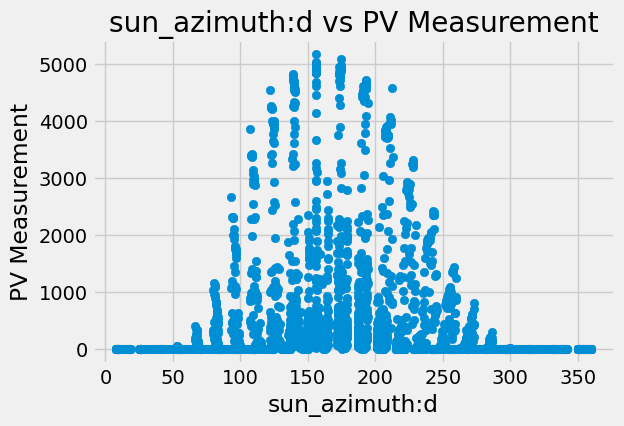

Correlation is -0.0490543796


In [96]:
# Choose what dataset you want your values from (observed = False gets the estimated dataset).
# Spesify hour (example: 12) and/or month (example: 6). Either of them can be None.
# Choose your feature. If you spesify 'feature' to be None, then it will plot for ALL feautures.

dataset = 'A'
observed = False
hour = None
month = None
feature = 'sun_azimuth:d'

plotter = DataPlotter(dataset)

corr = plotter.plot_feature_analysis(observed=observed, plot=True, feature=feature, hour=hour, month=month)
if corr is not None:
    print("Correlation is", round(corr, 10))


### Sorting on Correlation

The code snippet below will go through all combinations of hours, months and feature and sort the different cases on correlation. The output is a csv file. Note that this will take about 4-5 min to run on an Apple silicon M1 processor. 

- When running you might encounter the error "RuntimeWarning: Degrees of freedom <= 0 for slice". This happens when data you're working with is insufficient to compute that statistic. One common scenario is when computing the variance or standard deviation of a dataset with a single value or no values.
    - This makes since for some cases there are not many data points.

In [97]:
class Observation:
    def __init__(self, feature, hour, month, corr) -> None:
        self.feature = feature
        self.hour = hour
        self.month = month
        self.corr = corr

Altough we could have done the analysis of correlations without creating csv's, we chose to do so anyway. 

In [ ]:
# ITERATE THROUGH ALL COMBINATIONS OF MONTHS AND HOURS FOR A CHOSEN LOCATION AND SORT ON CORRELATION
# CREATES .CSV FILE
# NOTE Takes a long time to run

dataset = 'C'
observed = False

########################################################################################################################
plotter = DataPlotter(dataset)

if observed: all_features = plotter.get_all_features_observed()
else: all_features = plotter.get_all_features_estimated()

hours = list(range(24))
months = list(range(1, 13))

observations = []
for feature in all_features:
    for hour in hours:
        for month in months:
            corr = plotter.plot_feature_against_y(feature=feature, observed=observed, plot=False, hour=hour, month=month)
            obsvervation = Observation(feature, hour, month, corr)
            observations.append(obsvervation)

sorted_observations = sorted(observations, key=lambda x: -abs(x.corr))

if observed: csv_filename = "sorted_feature_correlations_" + dataset + "_observed.csv"
else: csv_filename = "sorted_feature_correlations_" + dataset + "_estimated.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Feature', 'Hour', 'Month', 'Correlation'])

    for obs in sorted_observations:
        row_data = [obs.feature, obs.hour, obs.month, obs.corr]
        csv_writer.writerow(row_data)

print(f"CSV file '{csv_filename}' has been created.")

### Analysing the Correlation Data

We can see that the feature correlations vary a lot with different hours and months. This is natural since, for instance, there is no sun at night time. Notice that the correlation of many features are much higher when approaching summer months as well.

To analyse the correlation data we can look at the average correlation of each feature irregardles of the hour or month. Then we can look at the same with hour and month in mind. Hence we can extrapolate what feature seem to be important.

In [101]:
# Choose location and observed/estimated, then run the analysis

location = 'B'
observed = True

if observed: csv_filename = '../' + location + "/sorted_feature_correlations_" + location + "_observed.csv"
else: csv_filename = '../' + location + "/sorted_feature_correlations_" + location + "_estimated.csv"

df_csv = pd.read_csv(csv_filename)

When looking at the average correlation of the features (ranked in the absolute value of the correlation) for all the locations we can state the following:

Location A:
- **direct_rad_1h:J** has the highest correlation for observed/estimated
 - Other top correlated features seem to be **effective_cloud_cover:p**, **total_cloud_cover:p**, **visibility:m** etc.

Location B:
 - **direct_rad:W** and **direct_rad_1h:J** are on top
 - **sun_elevation:d** has some higher importance here

 Location C:
  - **direct_rad_1h:J** and **direct_rad_1h:J** are on top

  Note that cloud cover has a negative correlation

In [102]:
avg_correlation = df_csv.groupby('Feature')['Correlation'].mean().reset_index()

avg_correlation.sort_values(by='Correlation', key=abs, ascending=False).head(10)

,Feature,Correlation
11,direct_rad:W,0.233218
12,direct_rad_1h:J,0.229888
37,sun_elevation:d,0.171454
13,effective_cloud_cover:p,-0.166713
3,clear_sky_energy_1h:J,0.153714
4,clear_sky_rad:W,0.150085
41,visibility:m,0.137576
29,relative_humidity_1000hPa:p,-0.133272
40,total_cloud_cover:p,-0.133161
5,cloud_base_agl:m,0.131772


### Now including hour and month in our analysis

**NOTE:** Some correlations are 1 or -1. This is because some instances might have only one or two datapoints leading to an inaccurate estimate of the correlation.

- We can look at the top correlated features for every month then for every hour.

In [103]:
# Outputs top features with the highest correlations when INCLUDING HOUR AND MONTH

df_csv = pd.read_csv(csv_filename)
df_csv.head(10)

,Feature,Hour,Month,Correlation
0,clear_sky_energy_1h:J,8,11,0.830680
1,clear_sky_rad:W,8,11,0.823640
2,is_in_shadow:idx,8,11,-0.811408
3,direct_rad_1h:J,8,10,0.792964
4,diffuse_rad_1h:J,8,11,0.791008
5,diffuse_rad:W,8,11,0.790991
6,direct_rad:W,8,10,0.787655
7,clear_sky_energy_1h:J,10,11,0.785969
8,diffuse_rad:W,13,11,0.784049
9,clear_sky_rad:W,10,11,0.783330


### What does the every month analysis tell us?

- When analysing the observed data for all three locations the summer month seem to be more reliant on radiation. Whilst in the winter months features like **absolute_humidity_2m:gm3** and **clear_sky_energy_1h:J** takes over (locations B and C, but not A).
- The analysis seems to break down for the estimated datasets due to the skewed correlations, because of the lack of sufficient data.

In [104]:
# The most highly correlated value for EVERY MONTH

df_csv['Month'] = pd.Categorical(df['Month'], categories=df['Month'].unique(), ordered=True)
max_corr_rows = pd.DataFrame()

for month in df_csv['Month'].cat.categories:
    monthly_data = df_csv[df_csv['Month'] == month]
    
    max_corr_idx = monthly_data['Correlation'].idxmax()
    
    max_corr_rows = pd.concat([max_corr_rows, df_csv.loc[[max_corr_idx]]], ignore_index=True)

# Sort max_corr_rows by the 'Month' column
max_corr_rows['Month'] = max_corr_rows['Month'].astype(int)  # Ensure 'Month' is an integer type for proper sorting
max_corr_rows.sort_values('Month', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows

,Feature,Hour,Month,Correlation
0,direct_rad:W,14,1,0.503278
1,absolute_humidity_2m:gm3,15,2,0.557116
2,direct_rad:W,8,3,0.401765
3,direct_rad:W,7,4,0.751622
4,direct_rad:W,7,5,0.767097
5,direct_rad:W,9,6,0.779392
6,direct_rad_1h:J,5,7,0.705664
7,sun_azimuth:d,16,8,0.621222
8,direct_rad_1h:J,6,9,0.733117
9,direct_rad_1h:J,8,10,0.792964


### What does the every hour analysis tell us?

- At nighttime these feature appear more often:
    - **date_forecast**
    - **visibility:m**
    - **sfc_pressure:hPa** 
------------------------------------
- At daytime these features dominate:
    - **Radiation (direct early in the morning, then diffuse radiontion in the afternoon)**
    - **clear_sky_energy_1h:J**

In [38]:
# The most highly correlated value for EVERY HOUR

max_corr_rows = pd.DataFrame()

for hour in range(0, 24):  
    hourly_data = df_csv[df_csv['Hour'] == hour]
    
    if not hourly_data.empty:  
        max_corr_idx = hourly_data['Correlation'].idxmax()
        max_corr_rows = pd.concat([max_corr_rows, df_csv.loc[[max_corr_idx]]], ignore_index=True)

max_corr_rows.sort_values('Hour', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows

,Feature,Hour,Month,Correlation
0,date_forecast,0,9,0.585378
1,date_forecast,1,9,0.575023
2,date_forecast,2,9,0.575023
3,date_forecast,3,9,0.575023
4,direct_rad:W,4,5,0.666494
5,direct_rad_1h:J,5,6,0.709759
6,direct_rad_1h:J,6,9,0.733117
7,diffuse_rad_1h:J,7,10,0.770198
8,clear_sky_energy_1h:J,8,11,0.830680
9,direct_rad:W,9,6,0.779392


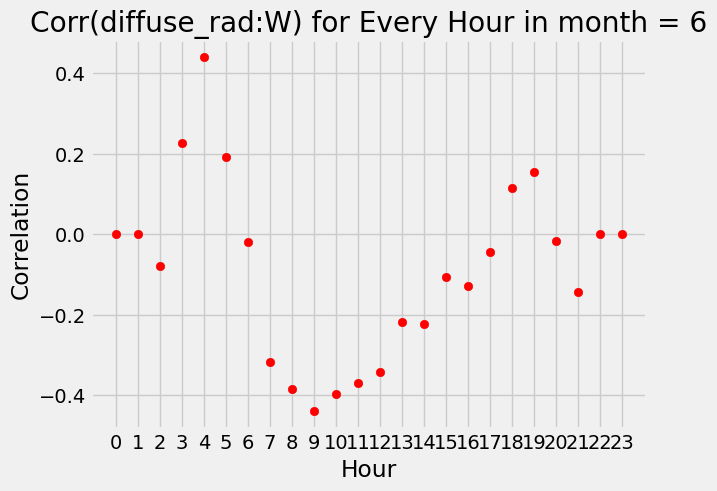

In [107]:
# Plot a the correlation of a feature for a spesific month for every hour
# Choose month and feature

month = 6
feature = 'diffuse_rad:W'

filtered_data = df_csv[(df_csv['Feature'] == feature) & (df_csv['Month'] == month)]

# Creating a scatter plot of the correlation values for each hour.
plt.scatter(filtered_data['Hour'], filtered_data['Correlation'], color='red')
plt.xticks(range(0, 24))  
plt.title('Corr(' + feature + ') for Every Hour in month = ' + str(month))
plt.xlabel('Hour')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

### Plotting pv measurment against time for all three locations

Thing of notice:
- Location B and C has missing datapoints at some point
- The amplitude of the readings from location A are much higher than the other two locations.
    - This could happen if for example location A has more solar pannels
- Possible solutions could be to use min-max scaling

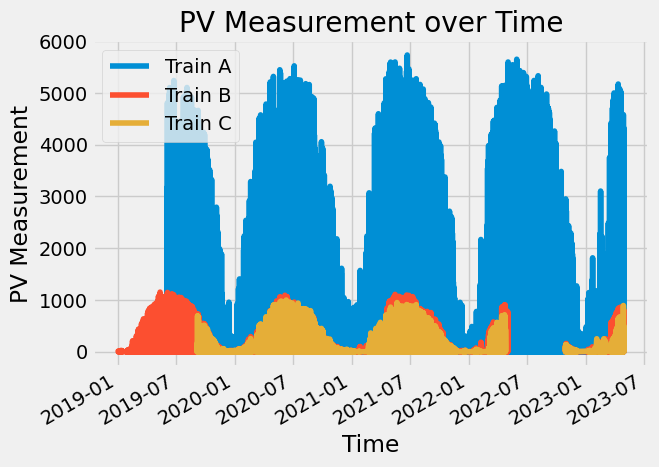

In [108]:
fig, ax = plt.subplots()

train_a.plot(x='time', y='pv_measurement', ax=ax, label='Train A')
train_b.plot(x='time', y='pv_measurement', ax=ax, label='Train B')
train_c.plot(x='time', y='pv_measurement', ax=ax, label='Train C')

ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()

plt.show()

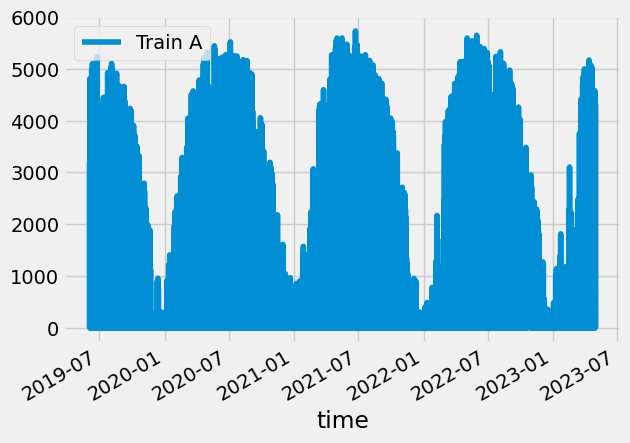

In [109]:
train_a.plot(x='time', y='pv_measurement', label='Train A')
ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()
plt.show()

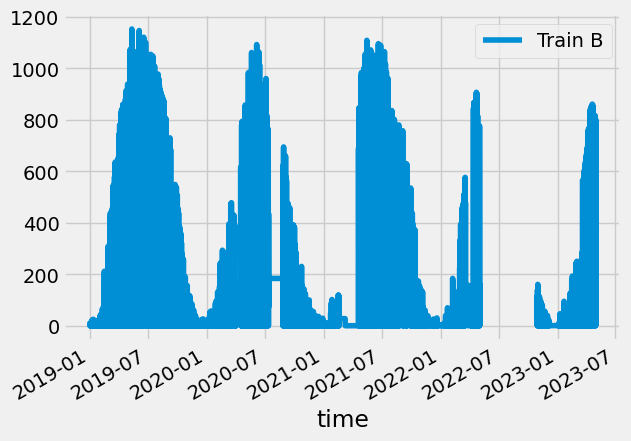

In [42]:
train_b.plot(x='time', y='pv_measurement', label='Train B')
ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()
plt.show()

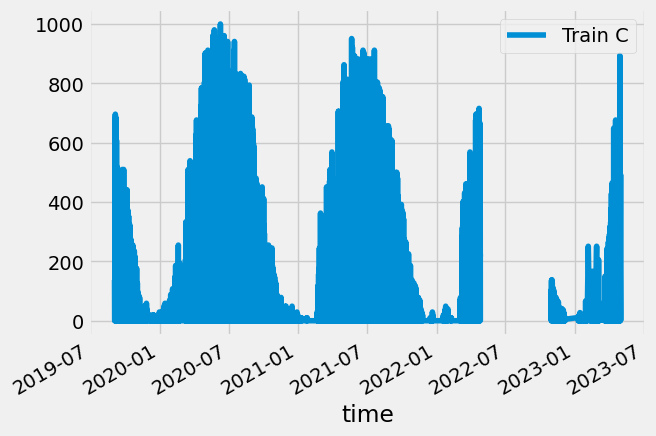

In [110]:
train_c.plot(x='time', y='pv_measurement', label='Train C')
ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()
plt.show()

### Let us examin both the observed and estimated dataset for all the locations starting with A

We will examine 
- Datashapes
- Datatypes
- Columns
- NaN values
- Some plots
- A correlation matrix

In [111]:
X_train_estimated_a.shape, X_train_observed_a.shape, X_train_estimated_b.shape, X_train_observed_b.shape, X_train_estimated_c.shape, X_train_observed_c.shape

((17576, 47),
 (118669, 46),
 (17576, 47),
 (116929, 46),
 (17576, 47),
 (116825, 46))

In [112]:
X_train_observed_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [113]:
X_train_estimated_b.dtypes

date_calc                         datetime64[us]
date_forecast                     datetime64[us]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm                        float32
fresh_snow_3h:cm                         float32
fresh_snow_6h:cm    

In [114]:
# Check NaN values

datasets = {
    "X_train_estimated_a": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/A/X_train_estimated.parquet'),
    "X_train_estimated_b": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/B/X_train_estimated.parquet'),
    "X_train_estimated_c": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/C/X_train_estimated.parquet'),
    "X_train_observed_a": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/A/X_train_observed.parquet'),
    "X_train_observed_b": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/B/X_train_observed.parquet'),
    "X_train_observed_c": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/C/X_train_observed.parquet'),
    "X_test_estimated_a": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/A/X_test_estimated.parquet'),
    "X_test_estimated_b": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/B/X_test_estimated.parquet'),
    "X_test_estimated_c": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/C/X_test_estimated.parquet'),
    "train_targets_a": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/A/train_targets.parquet'),
    "train_targets_b": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/B/train_targets.parquet'),
    "train_targets_c": pd.read_parquet('/Users/simenstang/Documents/TDT4173/data/C/train_targets.parquet')

}

for dataset_name, dataset in datasets.items():
    print(f"Checking NaN values in {dataset_name}:")
    
    # Assuming the first column is named 'date'. If not, adjust the name accordingly.
    features = dataset.columns[1:]
    
    for feature in features:
        nan_count = dataset[feature].isna().sum()
        
        if nan_count > 0:
            print(f"  - Number of NaN values in {feature}: {nan_count}")
    
    print("\n")


Checking NaN values in X_train_estimated_a:
  - Number of NaN values in ceiling_height_agl:m: 3919
  - Number of NaN values in cloud_base_agl:m: 2094
  - Number of NaN values in snow_density:kgm3: 15769


Checking NaN values in X_train_estimated_b:
  - Number of NaN values in ceiling_height_agl:m: 3689
  - Number of NaN values in cloud_base_agl:m: 1963
  - Number of NaN values in snow_density:kgm3: 15713


Checking NaN values in X_train_estimated_c:
  - Number of NaN values in ceiling_height_agl:m: 4596
  - Number of NaN values in cloud_base_agl:m: 2804
  - Number of NaN values in snow_density:kgm3: 13898


Checking NaN values in X_train_observed_a:
  - Number of NaN values in ceiling_height_agl:m: 22247
  - Number of NaN values in cloud_base_agl:m: 8066
  - Number of NaN values in snow_density:kgm3: 115945


Checking NaN values in X_train_observed_b:
  - Number of NaN values in ceiling_height_agl:m: 18772
  - Number of NaN values in cloud_base_agl:m: 7473
  - Number of NaN values in s

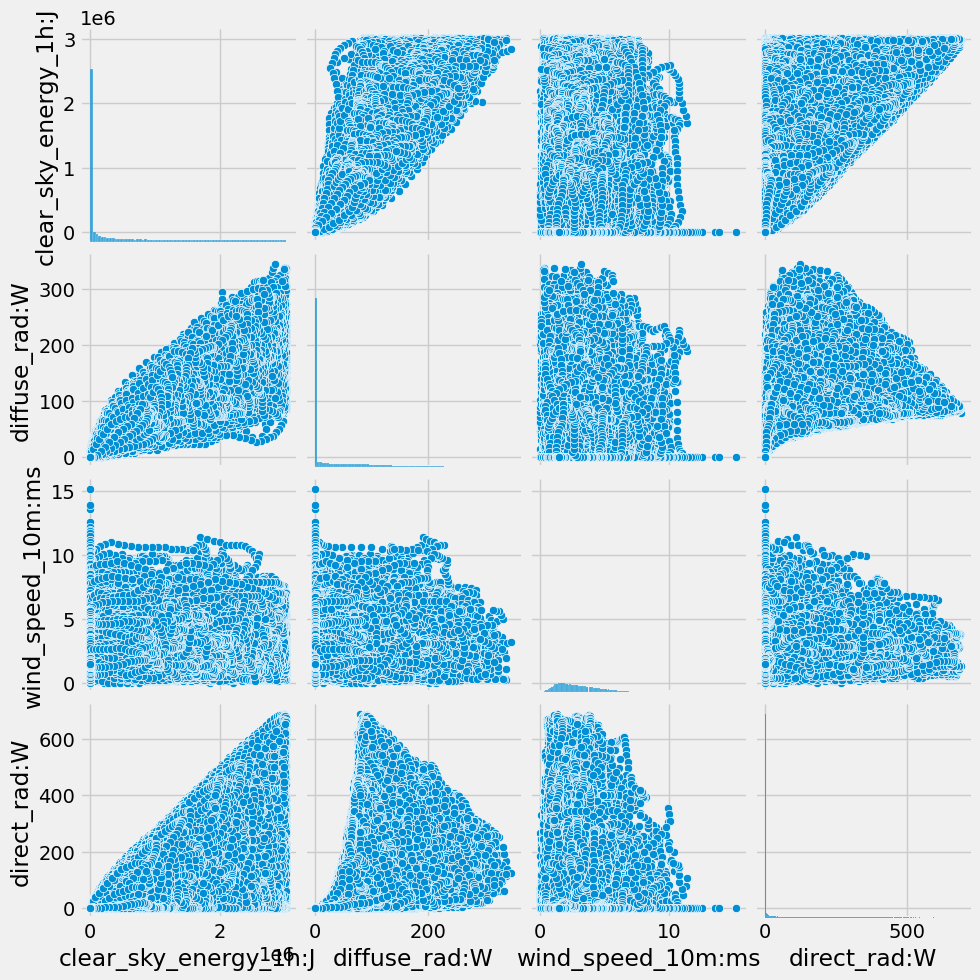

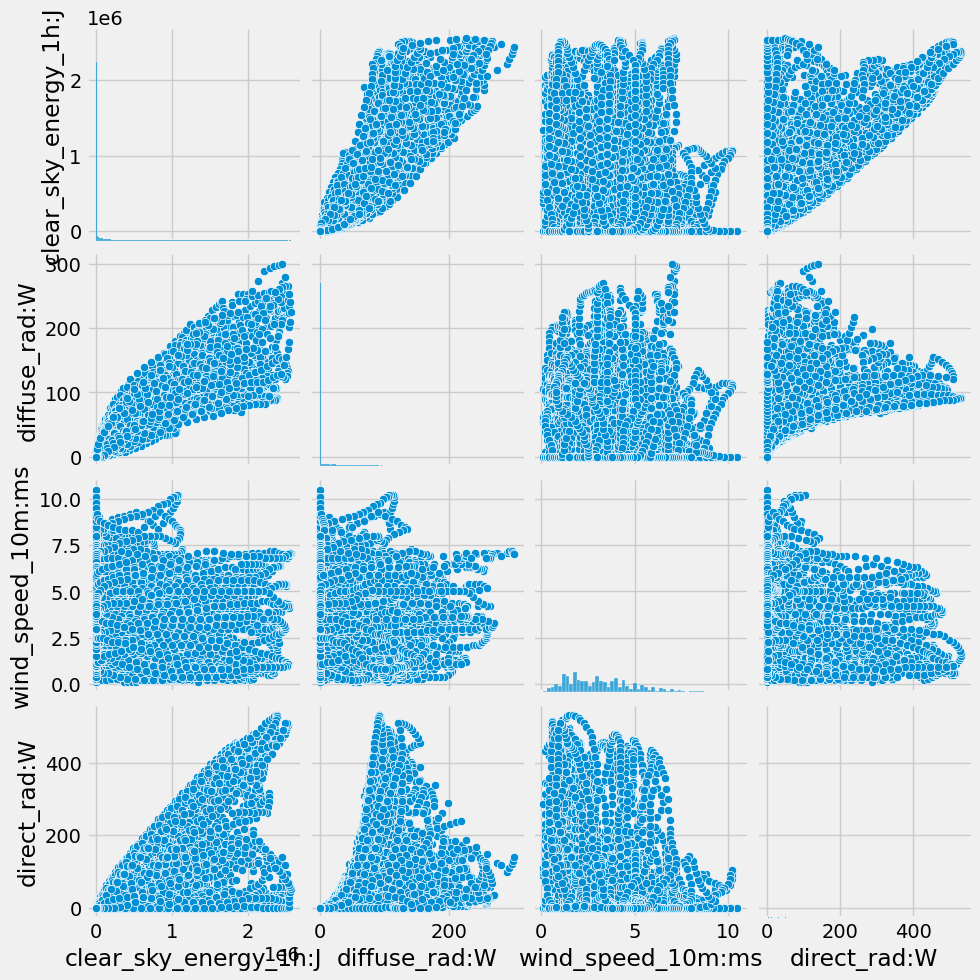

In [115]:
sns.pairplot(X_train_observed_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
sns.pairplot(X_train_estimated_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
plt.show()

In [54]:
df_corr = X_train_observed_a[X_train_observed_a.columns].dropna().corr()

In [55]:
def plot_corr_heatmap(df):
    
    corr = df_corr

    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(15, 10))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
    plt.title(f'Correlation Heatmap')
    plt.show()

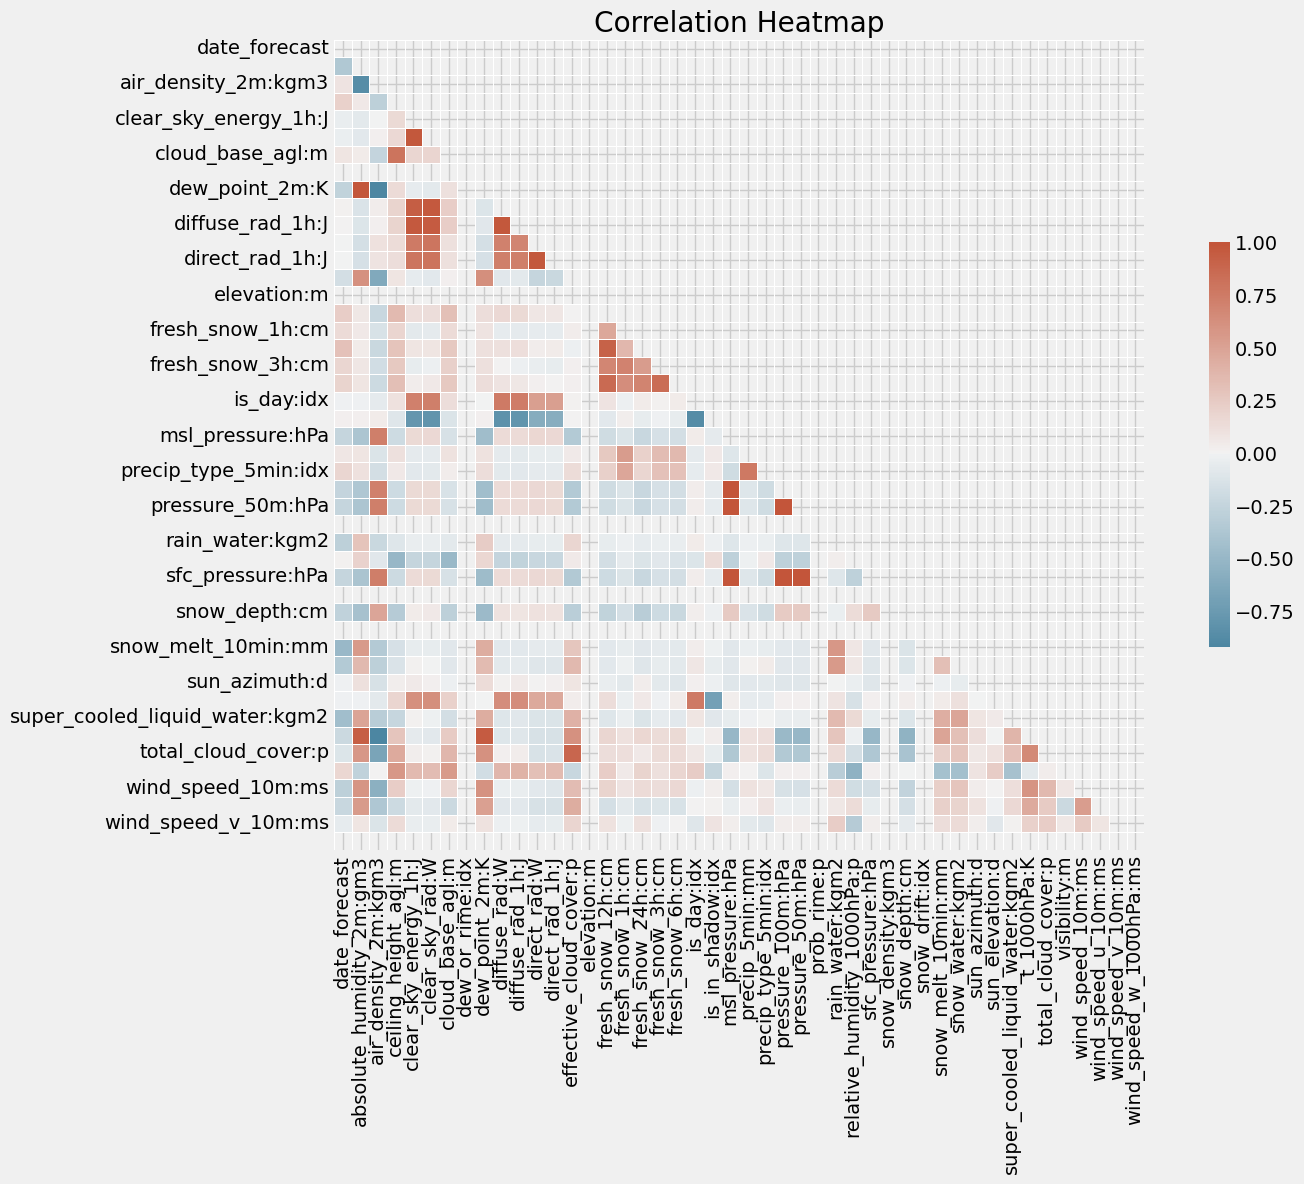

In [56]:
plot_corr_heatmap(X_train_observed_a.columns)

### Visualizing the date discrepancies

Also including the test sets.

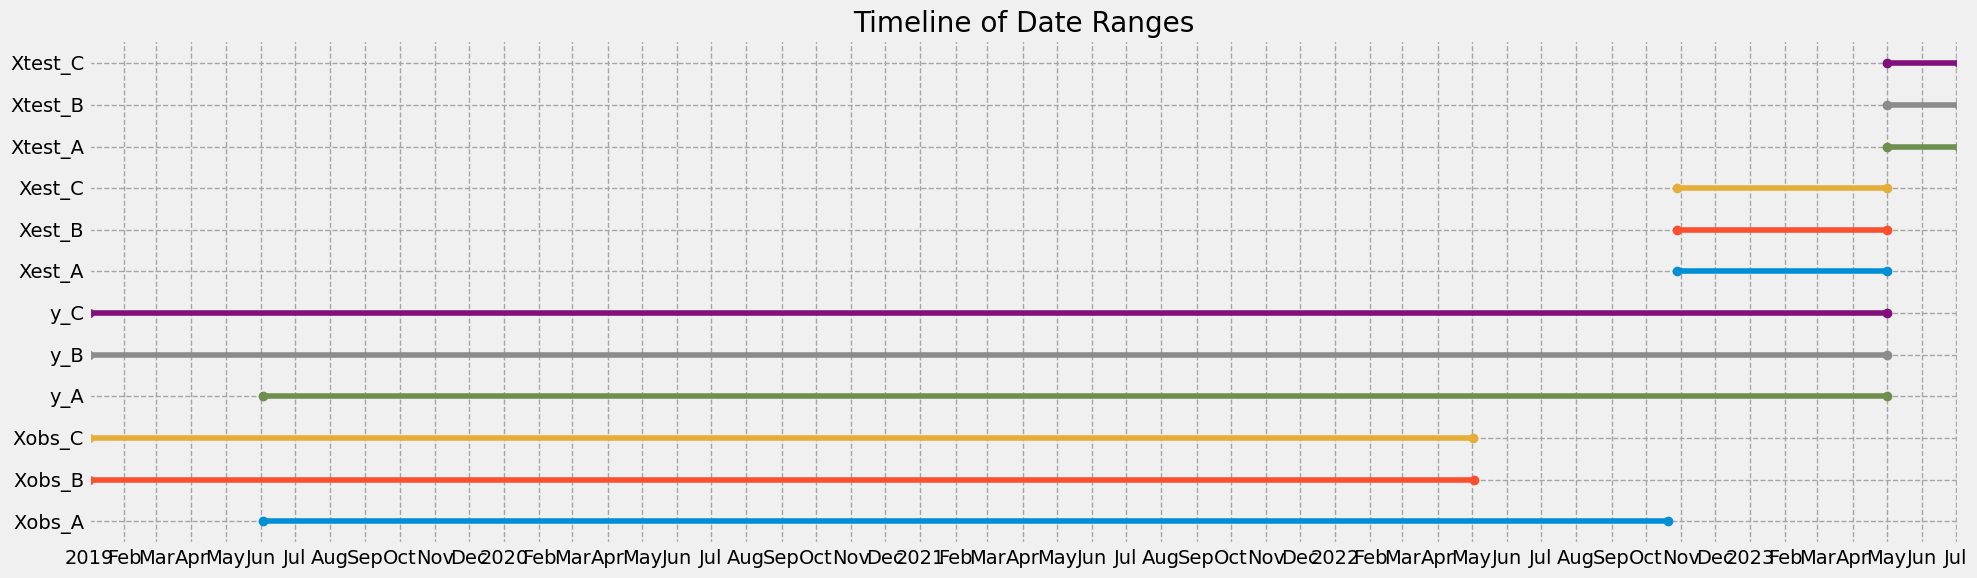

,label,min,max
0,Xobs_A,2019-06-02 22:00:00,2022-10-21 01:00:00
1,Xobs_B,2019-01-01 00:00:00,2022-05-03 00:00:00
2,Xobs_C,2019-01-01 00:00:00,2022-05-01 22:00:00
3,y_A,2019-06-02 22:00:00,2023-04-30 23:00:00
4,y_B,2018-12-31 23:00:00,2023-04-30 23:00:00
5,y_C,2018-12-31 23:00:00,2023-04-30 23:00:00
6,Xest_A,2022-10-28 22:00:00,2023-04-30 23:45:00
7,Xest_B,2022-10-28 22:00:00,2023-04-30 23:45:00
8,Xest_C,2022-10-28 22:00:00,2023-04-30 23:45:00
9,Xtest_A,2023-05-01 00:00:00,2023-07-03 23:45:00


In [116]:
import matplotlib.dates as mdates

dataframes = [
            X_train_observed_a, X_train_observed_b, X_train_observed_c, 
            train_a, train_b, train_c,
            X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, 
            X_test_estimated_a, X_test_estimated_b, X_test_estimated_c
            ]

labels = ['Xobs_A', 'Xobs_B', 'Xobs_C', 'y_A', 'y_B', 'y_C', 'Xest_A', 'Xest_B', 'Xest_C' 
          ,'Xtest_A', 'Xtest_B', 'Xtest_C' ]

date_cols = [
    'date_forecast', 'date_forecast', 'date_forecast', 
    'time', 'time', 'time', 
    'date_forecast', 'date_forecast', 'date_forecast',
    'date_forecast', 'date_forecast', 'date_forecast'
]

min_max_dates = [(df[col].min(), df[col].max()) for df, col in zip(dataframes, date_cols)]

data = {'label': [], 'min': [], 'max': []}
for df, col, lab in zip(dataframes, date_cols, labels):
    data['label'].append(lab)
    data['min'].append(df[col].min())
    data['max'].append(df[col].max())
table = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim(min(date[0] for date in min_max_dates), max(date[1] for date in min_max_dates))
ax.set_yticks(range(len(min_max_dates)))
ax.set_yticklabels([label for label in labels])
ax.set_title('Timeline of Date Ranges')

for index, (start, end) in enumerate(min_max_dates):
    ax.plot([start, end], [index, index], marker='o', linestyle='-')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

ax.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()

plt.show()

table

The timeline us useful to have when building the training and test datasets, and during modelling.  

### Conclusion

- None of the datasets have duplicates
- The dates have an incremeants in chuncks of 15 min. Note this might be important as we are asked to predict for every hour, we might possibly have to take the average for the four quarters in every hour.
- The correlations between some select features differ slighly for every location (might have to research this point even further) 
- From the describe()-method it seems that location B and C have the same earliest recording in 2018, whilst A has it in 2019. This is in opposition to a graph shown some place above.
    - Notice that the number of rows in train_a, train_b and train_c differ
    - Even though the PV measurment of locaton A is much higher, the mean values for the features in the observed datasets of the different location are more or less the same. Hence the "scaling" issue seems to be exclusive to the y_sets.

## DATA CLEANING AND PREPROCESSING

A short summary:
- Many things have been tried, we will walk you through most of it. It includes:
    - Removing constants, replacing them with NaNs, and making a new train set where y-data is modelled.
    - Removing the night, defined as sum(is_day) = 0 when resampled on 60 min. Hence only training and predicting during the day, and setting the night to zero in postprocessing. 
    - Normalization of all values
    - MORE?
- Generally, removing constant pv_measurements and setting them to NaN, performed best. 

## Fixing the x set

Start with the "basic fix"

In [117]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b, 
                     X_train_estimated_b, X_train_observed_c, X_train_estimated_c], ignore_index=True)

X = X.drop("date_calc", axis=1)
X.set_index('date_forecast', inplace=True)
X = X.sort_index()

print(X.shape)
X.head()

(405151, 45)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.6,1.240,1153.599976,0.0,0.0,1153.599976,1.0,275.200012,0.0,0.0,...,12.989000,-49.178001,0.0,278.500000,68.500000,18220.400391,2.5,1.1,2.2,-0.0
2019-01-01 00:00:00,5.6,1.239,1226.400024,0.0,0.0,1226.400024,0.0,275.399994,0.0,0.0,...,12.985000,-49.139999,0.0,278.399994,73.900002,19275.900391,2.5,1.1,2.2,-0.0
2019-01-01 00:15:00,5.5,1.241,1137.900024,0.0,0.0,1137.900024,1.0,275.100006,0.0,0.0,...,18.214001,-48.724998,0.0,278.399994,80.800003,17083.699219,2.8,1.1,2.5,-0.0
2019-01-01 00:15:00,5.6,1.239,1209.300049,0.0,0.0,1209.300049,0.0,275.200012,0.0,0.0,...,18.205999,-48.688000,0.0,278.299988,83.800003,17638.000000,2.7,1.2,2.4,-0.0
2019-01-01 00:30:00,5.5,1.240,1192.099976,0.0,0.0,1192.099976,0.0,275.100006,0.0,0.0,...,23.339001,-48.091000,0.0,278.200012,91.199997,16008.799805,2.9,1.2,2.7,-0.0


In [118]:
df_resampled = X.resample('60min').median()

## Fixing the y set

In [119]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

In [120]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


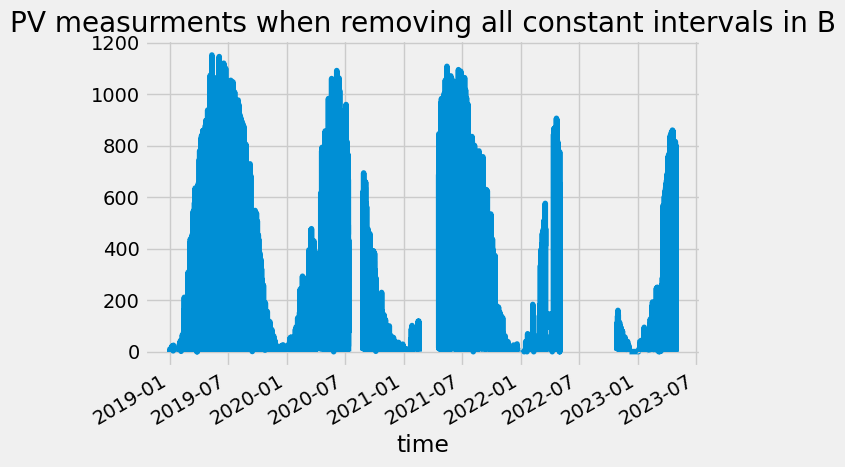

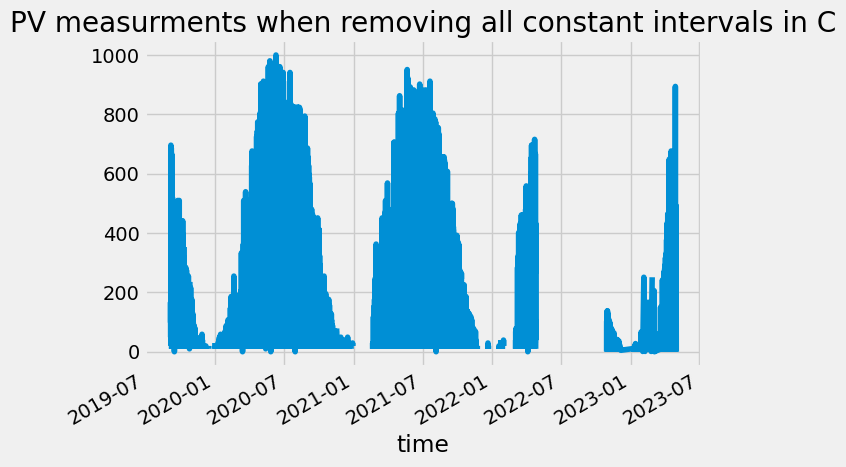

In [62]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [63]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [65]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [66]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [67]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


In [68]:
def process_data(df):
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    if "date_calc" in df.columns:
        df.drop("date_calc", axis=1, inplace=True)
    return df.resample('60min').median()

In [69]:
X_train_observed_a = process_data(X_train_observed_a)
X_train_estimated_a = process_data(X_train_estimated_a)
X_train_observed_b = process_data(X_train_observed_b)
X_train_estimated_b = process_data(X_train_estimated_b)
X_train_observed_c = process_data(X_train_observed_c)
X_train_estimated_c = process_data(X_train_estimated_c)

In [70]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [71]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)
    #median_value = df[feature].median()

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

In [72]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa']

# 'air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa', 'wind_speed_10m:ms',
# 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms'

#0.04391554145075651

for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [73]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [74]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

In [75]:
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [76]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,-48.389500,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,-48.426498,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,-45.002501,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,-44.971498,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,-39.896000,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0


### Dropping Nighttime Rows. 

Conclusion: did not work. Our hypothesis was that training on the night was a waste of time because there are no production when the sun has been down the entire is down, and hence not necassary to try and find any correlations and patterns durinng the night. 

In [121]:
def process_dataset_nighttime_mod(df):
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    if "date_calc" in df:
        df.drop("date_calc", axis=1, inplace=True)
    agg_methods = {col: 'median' for col in df.columns}
    agg_methods['is_day:idx'] = 'sum'
    return df.resample('60min').agg(agg_methods)

# Applying the function to each dataset
X_train_observed_a = process_dataset_nighttime_mod(X_train_observed_a)
X_train_estimated_a = process_dataset_nighttime_mod(X_train_estimated_a)
X_train_observed_b = process_dataset_nighttime_mod(X_train_observed_b)
X_train_estimated_b = process_dataset_nighttime_mod(X_train_estimated_b)
X_train_observed_c = process_dataset_nighttime_mod(X_train_observed_c)
X_train_estimated_c = process_dataset_nighttime_mod(X_train_estimated_c)

In [124]:
X_train_estimated_a['is_day:idx'].head(24)

date_forecast
2022-10-28 22:00:00    0.0
2022-10-28 23:00:00    0.0
2022-10-29 00:00:00    0.0
2022-10-29 01:00:00    0.0
2022-10-29 02:00:00    0.0
2022-10-29 03:00:00    0.0
2022-10-29 04:00:00    0.0
2022-10-29 05:00:00    0.0
2022-10-29 06:00:00    0.0
2022-10-29 07:00:00    4.0
2022-10-29 08:00:00    4.0
2022-10-29 09:00:00    4.0
2022-10-29 10:00:00    4.0
2022-10-29 11:00:00    4.0
2022-10-29 12:00:00    4.0
2022-10-29 13:00:00    4.0
2022-10-29 14:00:00    4.0
2022-10-29 15:00:00    1.0
2022-10-29 16:00:00    0.0
2022-10-29 17:00:00    0.0
2022-10-29 18:00:00    0.0
2022-10-29 19:00:00    0.0
2022-10-29 20:00:00    0.0
2022-10-29 21:00:00    0.0
Freq: 60T, Name: is_day:idx, dtype: float32

In [87]:
test_df = df.copy()

In [88]:
test_df = test_df[test_df['is_day:idx'] > 0]

In [89]:
test_df.shape, df.shape

((37358, 62), (53759, 62))

## FEATURE ENGINEERING

This part will walk you through the things we have tried related to feature engineering. 
It includes: 
- Treating the problem as time series or not. Means having "temporal features" like hour, day of week, week of year etc. 
- Including interaction terms to capture the effects of interaction between features and enable more non linear relationships. 
- Including some ratios. 
- Transformations of relevant features. 
- One hot encoding of location and observed vs estimated.


In [81]:
def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

In [82]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

In [80]:
df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,3,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.223333,2.550000e+08
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,3,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.227706,2.650000e+08
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,3,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.231776,3.350000e+08
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,3,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.229537,3.200000e+08
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,3,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.229352,3.450000e+08


In [83]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [84]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [85]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              43484
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 45327 ROWS BEING DROPPED. THE DATASET HAS 53759 ROWS IN TOTAL.


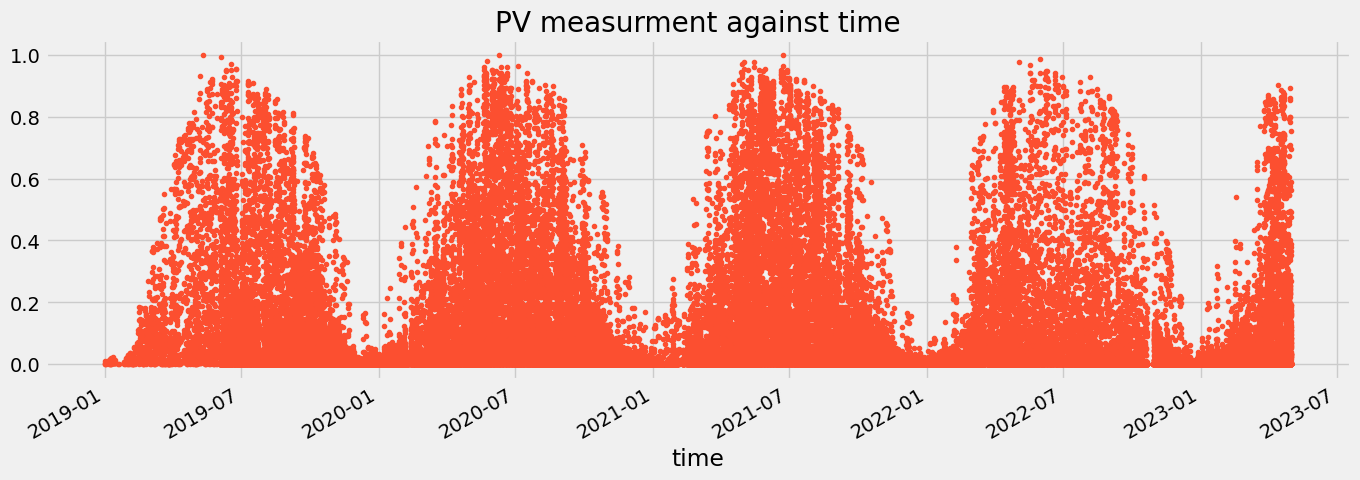

In [86]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()